In [1]:
import dLux as dl
import dLux.utils as dlu
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
from jax import device_count

In [27]:
wf_npix = 512
diameter = 0.125
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)

psf_npix = 64
psf_pixel_scale = 0.375 #arcsec
oversample = 16

layers = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    )
]

optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample
)

wavelength = 585e-9

fluxes = np.logspace(2, 2, 1)
print(fluxes)
num_trials = 10 # 10 just takes so long

# numpyro stuff
parameters = ['wavelengths']

def psf_model(data, model):
    
    values = [
        npy.sample("wavelength",    dist.Uniform(wavelength*0.9, wavelength*1.1))
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten()
        )
        return npy.sample("psf", poisson_model, obs=data.flatten())
    
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),
    num_warmup=200,
    num_samples=200,
    num_chains=device_count(),
    progress_bar=True,
)

#rmax and cramer rao bound functions
def rmax(psf_pixel_scale, psf_npix):
    rmax = np.sqrt(2)*dlu.arcsec2rad(psf_npix * psf_pixel_scale/2) # divide by 2 for radius, sqrt2 because more pixels along the diagonal.
    return rmax

our_rmax = rmax(psf_pixel_scale, psf_npix)

def crb(wavelength, flux, diameter, rmax):
    crb = wavelength**(3/2)/(2*(flux*(2*diameter*rmax - wavelength))**0.5)
    return crb

[100.]


In [3]:
square_errors_by_flux = []
cramer_rao_bounds = []

for flux in fluxes:
    source = dl.PointSource(np.array([wavelength]),flux = flux)
    telescope = dl.Telescope(optics, ('source', source))
    psf = telescope.model()

    flux_errors = []

    for i in np.arange(num_trials):
        key = jr.PRNGKey(i)
        data = jr.poisson(key, psf)

        %time sampler.run(jr.PRNGKey(0), data, telescope)
        samples = sampler.get_samples()
        median = np.median(samples['wavelength'].flatten())
        square_error = (median - wavelength)**2
        flux_errors.append(square_error)

    square_errors_by_flux.append(flux_errors)
    
    crb_flux = crb(wavelength, flux, diameter, our_rmax)
    cramer_rao_bounds.append(crb_flux)

sample: 100%|██████████| 400/400 [02:33<00:00,  2.61it/s, 1 steps of size 8.86e-01. acc. prob=0.93] 


CPU times: user 15min 50s, sys: 10.8 s, total: 16min 1s
Wall time: 2min 37s


sample: 100%|██████████| 400/400 [02:51<00:00,  2.33it/s, 7 steps of size 8.54e-01. acc. prob=0.93] 


CPU times: user 17min 47s, sys: 11.9 s, total: 17min 59s
Wall time: 2min 51s


sample: 100%|██████████| 400/400 [03:09<00:00,  2.11it/s, 7 steps of size 1.20e+00. acc. prob=0.93] 


CPU times: user 19min 59s, sys: 12.2 s, total: 20min 12s
Wall time: 3min 9s


sample: 100%|██████████| 400/400 [03:01<00:00,  2.20it/s, 7 steps of size 7.32e-01. acc. prob=0.93] 


CPU times: user 19min 10s, sys: 11.9 s, total: 19min 22s
Wall time: 3min 1s


sample: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s, 3 steps of size 1.16e+00. acc. prob=0.90] 


CPU times: user 17min 33s, sys: 10.4 s, total: 17min 44s
Wall time: 2min 46s


sample: 100%|██████████| 400/400 [03:15<00:00,  2.05it/s, 3 steps of size 3.21e-01. acc. prob=0.92] 


CPU times: user 20min 30s, sys: 11.9 s, total: 20min 42s
Wall time: 3min 15s


sample: 100%|██████████| 400/400 [02:38<00:00,  2.53it/s, 1 steps of size 1.02e+00. acc. prob=0.92] 


CPU times: user 16min 30s, sys: 9.29 s, total: 16min 39s
Wall time: 2min 38s


sample: 100%|██████████| 400/400 [03:34<00:00,  1.86it/s, 7 steps of size 1.77e-01. acc. prob=0.93]  


CPU times: user 22min 40s, sys: 12.6 s, total: 22min 52s
Wall time: 3min 35s


sample: 100%|██████████| 400/400 [02:33<00:00,  2.60it/s, 3 steps of size 1.08e+00. acc. prob=0.92] 


CPU times: user 16min 20s, sys: 7.91 s, total: 16min 28s
Wall time: 2min 34s


sample: 100%|██████████| 400/400 [02:30<00:00,  2.66it/s, 1 steps of size 9.59e-01. acc. prob=0.92] 


CPU times: user 15min 51s, sys: 8.18 s, total: 16min
Wall time: 2min 30s


In [8]:
variances = [np.mean(np.array(errors)) for errors in square_errors_by_flux]

In [24]:
print(square_errors_by_flux)
print(np.sqrt(variances[0]))
print(cramer_rao_bounds[0]**2)
print(crb(wavelength,100,diameter,dlu.arcsec2rad(psf_npix * psf_pixel_scale/2)))

[[Array(2.4922793e-17, dtype=float32), Array(7.362815e-17, dtype=float32), Array(2.2559862e-17, dtype=float32), Array(2.4717352e-18, dtype=float32), Array(8.889307e-18, dtype=float32), Array(2.3027181e-17, dtype=float32), Array(1.81668e-16, dtype=float32), Array(2.5366306e-17, dtype=float32), Array(1.359637e-16, dtype=float32), Array(1.03846094e-16, dtype=float32)]]
7.761077e-09
2.5045366e-17
5.987841076459987e-09


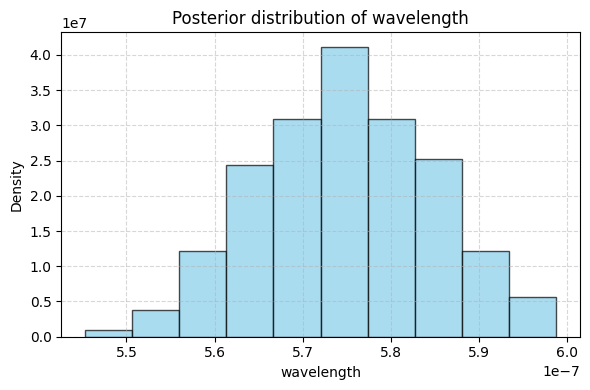

In [19]:
for param, values in samples.items():
    plt.figure(figsize=(6, 4))
    plt.hist(values.flatten(), bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f"Posterior distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [25]:
sampler.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  wavelength      0.00      0.00      0.00      0.00      0.00     88.77      1.00

Number of divergences: 1


In [ ]:
# main thing that caused this to take so long: oversample = 16!! not necessary.